In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.netto79 import Netto79Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

One-dimensional stochastic dynamical system due to Netto et al. [1] with state dynamics defined by discrete time map

\begin{equation}
  z_{t+1} = \alpha z_t + \beta \frac{z_t}{1 + z_t^2} + \gamma \cos(\delta t) + \sigma_z u_t
\end{equation}

with $u_t \sim \mathcal{N}(0, 1) ~\forall t$ and $z_0 \sim \mathcal{N}(m, s^2)$.

Observed process defined by

\begin{equation}
  x_{t} = \epsilon z_t^2 + \sigma_x v_t
\end{equation}

with $v_t \sim \mathcal{N}(0, 1)$.

Standard parameter values assumed here are $\alpha = 0.5$, $\beta = 25$, $\gamma = 8$, $\delta = 1.2$, $\epsilon = 0.05$, $m=10$, $s=5$, $\sigma_z^2 = 1$, $\sigma_x^2 = 10$ and $T = 100$ simulated time steps.

### References

  1. M. L. A. Netto, L. Gimeno, and M. J. Mendes. A new spline algorithm for non-linear filtering of discrete time systems. *Proceedings of the 7th Triennial World Congress*, 1979.

In [2]:
n_steps = 100
seed = 20171027
rng = np.random.RandomState(seed)
params = {
    'init_state_mean': 10.,
    'init_state_std': 5.,
    'state_noise_std': 1.,
    'obser_noise_std': 10.**0.5, 
    'alpha': 0.5,
    'beta': 25.,
    'gamma': 8,
    'delta': 1.2,
    'epsilon': 0.05,
}
locals().update(params)
model = Netto79Model(rng, **params)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

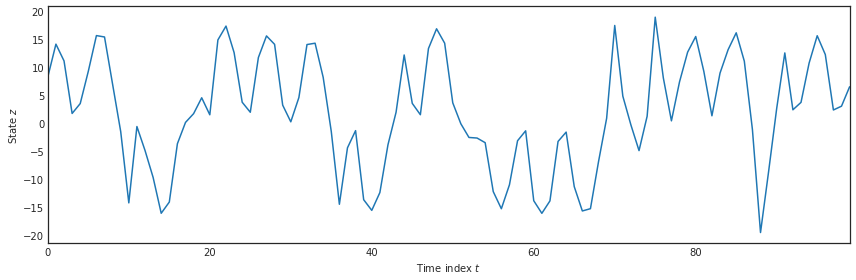

In [4]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference)
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State $z$')
_ = ax.set_xlim(0, n_steps - 1)
fig.tight_layout()

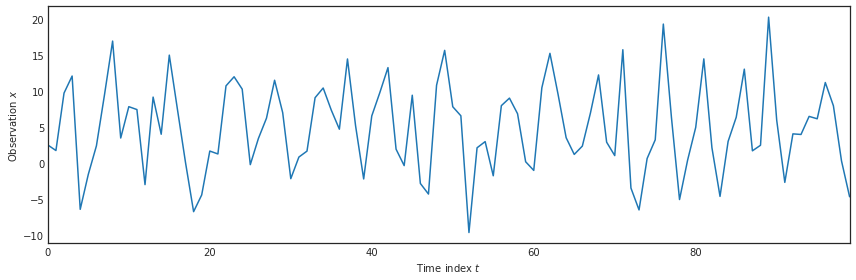

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference)
ax.set_xlabel('Time index $t$')
ax.set_ylabel('Observation $x$')
_ = ax.set_xlim(0, n_steps - 1)
fig.tight_layout()

## Infer state from observations

In [6]:
def plot_results(results, z_reference=None, plot_traces=True, plot_region=False, 
                 trace_skip=1, trace_alpha=0.25):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    ax.plot(results['z_mean_seq'][:, 0], 'g-', lw=1)
    if plot_region:
        ax.fill_between(
            np.arange(n_steps),
            results['z_mean_seq'][:, 0] - 3 * results['z_std_seq'][:, 0],
            results['z_mean_seq'][:, 0] + 3 * results['z_std_seq'][:, 0],
            alpha=0.25, color='g'
        )
    if plot_traces:
        ax.plot(results['z_particles_seq'][:, ::trace_skip, 0], 
                'r-', lw=0.25, alpha=trace_alpha)
    if z_reference is not None:
        ax.plot(z_reference[:, 0], 'k--')
    ax.set_ylabel('State $z$')
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, ax

### Ensemble Kalman filter (perturbed observations)

In [7]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng)

In [8]:
%%time
results_enkf = enkf.filter(x_reference, 1000, return_particles=True)

CPU times: user 568 ms, sys: 28 ms, total: 596 ms
Wall time: 304 ms


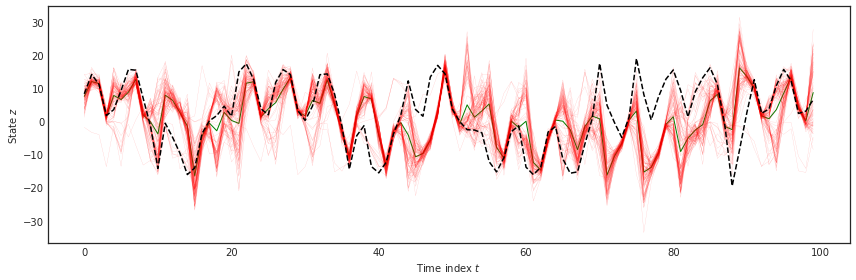

In [9]:
fig, ax = plot_results(results_enkf, z_reference, trace_skip=10)

### Ensemble Kalman filter (deterministic square root)

In [10]:
esrkf = da.EnsembleSquareRootFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_func, np.array([[model.obser_noise_std]]), rng)

In [11]:
%%time
results_esrkf = esrkf.filter(x_reference, 300, return_particles=True)

CPU times: user 1.85 s, sys: 16 ms, total: 1.86 s
Wall time: 938 ms


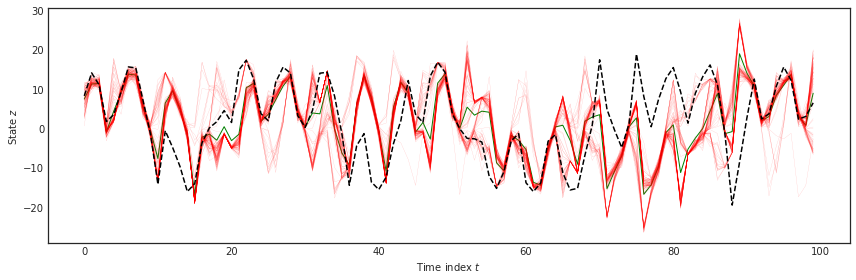

In [12]:
fig, ax = plot_results(results_esrkf, z_reference, trace_skip=3)

### Bootstrap particle filter

In [13]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng)

In [14]:
%%time
results_bspf = bspf.filter(x_reference, 1000, return_particles=True)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 67.9 ms


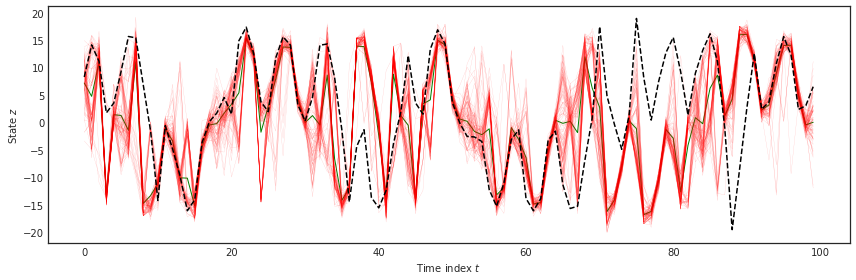

In [15]:
fig, ax = plot_results(results_bspf, z_reference, trace_skip=10)

### Ensemble transform particle filter

In [16]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng)

In [17]:
%%time
results_etpf = etpf.filter(x_reference, 300, return_particles=True)

CPU times: user 4.02 s, sys: 144 ms, total: 4.16 s
Wall time: 2.1 s


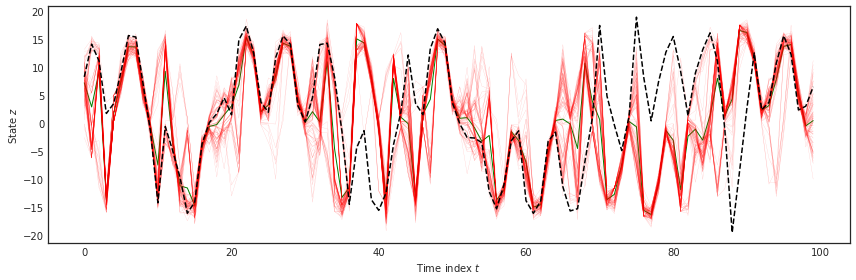

In [18]:
fig, ax = plot_results(results_etpf, z_reference, trace_skip=3)

### Visualise estimated means of filtering distribution

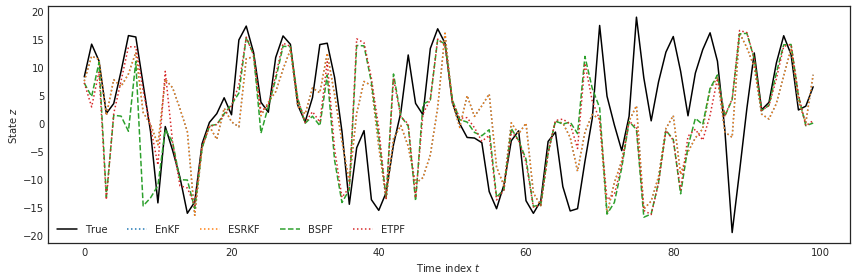

In [19]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, 0], 'k', label='True')
ax.plot(results_enkf['z_mean_seq'][:, 0], ':', label='EnKF')
ax.plot(results_enkf['z_mean_seq'][:, 0], ':', label='ESRKF')
ax.plot(results_bspf['z_mean_seq'][:, 0], '--', label='BSPF')
ax.plot(results_etpf['z_mean_seq'][:, 0], ':', label='ETPF')
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State $z$')
ax.legend(ncol=5)
fig.tight_layout()